In [37]:
pip install --upgrade dask distributed dask-ml dask-lightgbm dask-xgboost

Requirement already up-to-date: dask in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (2.21.0)
Requirement already up-to-date: distributed in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (2.21.0)
Requirement already up-to-date: dask-ml in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.5.0)
Requirement already up-to-date: dask-lightgbm in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (0.1.0)
Note: you may need to restart the kernel to use updated packages.


In [50]:
import dask
import glob
import joblib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from dask_lightgbm import LGBMRegressor
from dask_ml.xgboost import XGBRegressor
from azureml.core import Workspace, Dataset, Model

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='AzureML', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='cody-eastus-rg')

In [3]:
data_url = 'https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather'

for year in range(2008, 2020+1):
    ds = Dataset.File.from_files(f'{data_url}/year={year}/month=*/*.parquet', validate=False)
    print('Downloading...')
    %time ds.download(f'/tmp/data/isd/year={year}', overwrite=True)

Downloading...
CPU times: user 293 ms, sys: 54.4 ms, total: 347 ms
Wall time: 2min 9s
Downloading...
CPU times: user 118 ms, sys: 16.9 ms, total: 135 ms
Wall time: 5.72 s
Downloading...
CPU times: user 122 ms, sys: 5.58 ms, total: 128 ms
Wall time: 6.02 s
Downloading...
CPU times: user 122 ms, sys: 17 ms, total: 139 ms
Wall time: 2.24 s
Downloading...
CPU times: user 119 ms, sys: 7.76 ms, total: 127 ms
Wall time: 4.18 s
Downloading...
CPU times: user 119 ms, sys: 13.6 ms, total: 133 ms
Wall time: 4.44 s
Downloading...
CPU times: user 111 ms, sys: 22.8 ms, total: 134 ms
Wall time: 2.34 s
Downloading...
CPU times: user 128 ms, sys: 5.49 ms, total: 134 ms
Wall time: 1.93 s
Downloading...
CPU times: user 97.8 ms, sys: 9.26 ms, total: 107 ms
Wall time: 3.18 s
Downloading...
CPU times: user 112 ms, sys: 21.7 ms, total: 133 ms
Wall time: 2.32 s
Downloading...
CPU times: user 116 ms, sys: 8.46 ms, total: 124 ms
Wall time: 4.36 s
Downloading...
CPU times: user 133 ms, sys: 14.2 ms, total: 147 m

In [9]:
c = Client()
c

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45331 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:43957 Dashboard: http://127.0.0.1:45331/status,Cluster Workers: 16 Cores: 128 Memory: 4.11 TB


In [6]:
files = glob.glob('/tmp/data/isd/year=*/month=*/*.parquet')
files[-5:]

['/tmp/data/isd/year=2008/month=7/part-00006-tid-5510021478324055028-45dbadea-cc95-44c3-abcc-309987782144-4602-7.c000.snappy.parquet',
 '/tmp/data/isd/year=2008/month=7/part-00007-tid-5510021478324055028-45dbadea-cc95-44c3-abcc-309987782144-4605-7.c000.snappy.parquet',
 '/tmp/data/isd/year=2008/month=7/part-00001-tid-5510021478324055028-45dbadea-cc95-44c3-abcc-309987782144-4599-7.c000.snappy.parquet',
 '/tmp/data/isd/year=2008/month=7/part-00000-tid-5510021478324055028-45dbadea-cc95-44c3-abcc-309987782144-4601-7.c000.snappy.parquet',
 '/tmp/data/isd/year=2008/month=7/part-00005-tid-5510021478324055028-45dbadea-cc95-44c3-abcc-309987782144-4598-7.c000.snappy.parquet']

In [7]:
len(files)

1208

In [8]:
dfs = [dask.delayed(pd.read_parquet)(file) for file in files]
dfs[-5:]

[Delayed('read_parquet-3b79219d-d713-4ac9-bb21-6eb66845087d'),
 Delayed('read_parquet-038d18c9-c413-4657-8770-6b7b66eaf206'),
 Delayed('read_parquet-5a46913d-2a81-4f57-a132-5264b2aa47f3'),
 Delayed('read_parquet-567395c6-0704-463e-82a7-77227d9ef37d'),
 Delayed('read_parquet-5ac31cd5-aaf5-4275-856a-e2993948bf2f')]

In [10]:
df = dd.from_delayed(dfs)

In [11]:
df

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,cloudCoverage,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
npartitions=1208,,,,,,,,,,,,,,,,,,,,,,
,object,object,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,object,object,object,int32,int32,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [12]:
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,94074,2020-04-12 17:05:00,40.807,-104.755,1643.0,NaN,NaN,-5.2,NaN,...,NaN,NaN,NaN,NaN,NUNN 7 NNE,US,999999-94074,2020,12,1.0
1,999999,22016,2020-04-14 01:20:00,29.348,-103.209,1065.0,NaN,NaN,19.6,NaN,...,NaN,NaN,NaN,NaN,PANTHER JUNCTION 2 N,US,999999-22016,2020,14,1.0
2,999999,94074,2020-04-16 02:35:00,40.807,-104.755,1643.0,NaN,NaN,0.7,NaN,...,NaN,NaN,NaN,NaN,NUNN 7 NNE,US,999999-94074,2020,16,1.0
3,999999,53152,2020-04-02 16:55:00,34.414,-119.880,5.0,NaN,NaN,15.8,NaN,...,NaN,NaN,NaN,NaN,SANTA BARBARA 11 W,US,999999-53152,2020,2,1.0
4,999999,23904,2020-04-13 12:55:00,35.820,-91.781,139.0,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,BATESVILLE 8 WNW,US,999999-23904,2020,13,1.0


In [13]:
df.tail()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
1026716,725116,54737,2008-07-02 07:53:00,40.120,-76.294,123.0,260.0,2.6,16.7,1015.1,...,NaN,1.0,0.0,NaN,LANCASTER AIRPORT,US,725116-54737,2008,2,1.0
1026717,727720,24144,2008-07-21 06:53:00,46.606,-111.964,1179.0,0.0,0.0,20.0,1013.2,...,NaN,1.0,0.0,NaN,HELENA REGIONAL AIRPORT,US,727720-24144,2008,21,1.0
1026718,725046,14707,2008-07-05 02:56:00,41.328,-72.049,3.0,120.0,1.5,20.6,1016.6,...,NaN,1.0,0.0,NaN,GROTON-NEW LONDON AIRPORT,US,725046-14707,2008,5,1.0
1026719,727720,24144,2008-07-15 06:53:00,46.606,-111.964,1179.0,50.0,1.5,18.9,1014.4,...,NaN,1.0,0.0,NaN,HELENA REGIONAL AIRPORT,US,727720-24144,2008,15,1.0
1026720,725046,14707,2008-07-28 15:56:00,41.328,-72.049,3.0,220.0,3.6,22.2,1011.6,...,NaN,1.0,0.0,NaN,GROTON-NEW LONDON AIRPORT,US,725046-14707,2008,28,1.0


In [15]:
df = df.repartition(npartitions=128).persist()

In [16]:
%time len(df)

CPU times: user 28.2 s, sys: 4.47 s, total: 32.7 s
Wall time: 2min 20s


1478779330

In [17]:
%time len(df)

CPU times: user 142 ms, sys: 22.4 ms, total: 165 ms
Wall time: 179 ms


1478779330

In [18]:
%time df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist()

In [19]:
%time len(df)

CPU times: user 1min 31s, sys: 10.6 s, total: 1min 42s
Wall time: 5min 2s


1478779330

In [20]:
%time len(df)

CPU times: user 198 ms, sys: 14.3 ms, total: 212 ms
Wall time: 253 ms


1478779330

In [21]:
%time df.describe().compute()

CPU times: user 3min 10s, sys: 12.4 s, total: 3min 22s
Wall time: 4min 53s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.478779e+09,1.478779e+09,1.478779e+09,1.187044e+09,1.232841e+09,1.450766e+09,5.282017e+08,1.343759e+08,5.476352e+07,3.135997e+08,3.135997e+08,8.791192e+06,1.478779e+09,1.478779e+09,1.478779e+09
mean,3.739592e+01,-3.938308e+01,3.971325e+02,1.652594e+02,3.439796e+00,1.197424e+01,1.014671e+03,2.998942e+01,4.241606e+00,9.601276e+00,1.127185e+03,1.779858e+01,2.014093e+03,1.569218e+01,1.000000e+00
std,2.163519e+01,7.856125e+01,6.290371e+02,1.145104e+02,2.865657e+00,1.246929e+01,9.374051e+00,2.937402e+01,3.012358e+00,2.071308e+01,3.148221e+03,3.310977e+01,3.582164e+00,8.806178e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.401300e+01,-9.526000e+01,4.400000e+01,8.000000e+01,2.000000e+00,8.400000e+00,1.011600e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,1.100000e+01,1.000000e+00
50%,4.166900e+01,-7.112000e+01,2.000000e+02,1.900000e+02,3.100000e+00,1.620000e+01,1.017100e+03,5.000000e+01,5.000000e+00,1.000000e+00,0.000000e+00,1.500000e+01,2.016000e+03,2.000000e+01,1.000000e+00
75%,4.916600e+01,1.753300e+01,5.500000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026300e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.200000e+01,2.020000e+03,2.700000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.020000e+03,3.100000e+01,1.000000e+00


In [23]:
%time places = df.groupby(df.index)[['longitude', 'latitude', 'year']].mean().compute()

CPU times: user 4.6 s, sys: 374 ms, total: 4.97 s
Wall time: 5.45 s


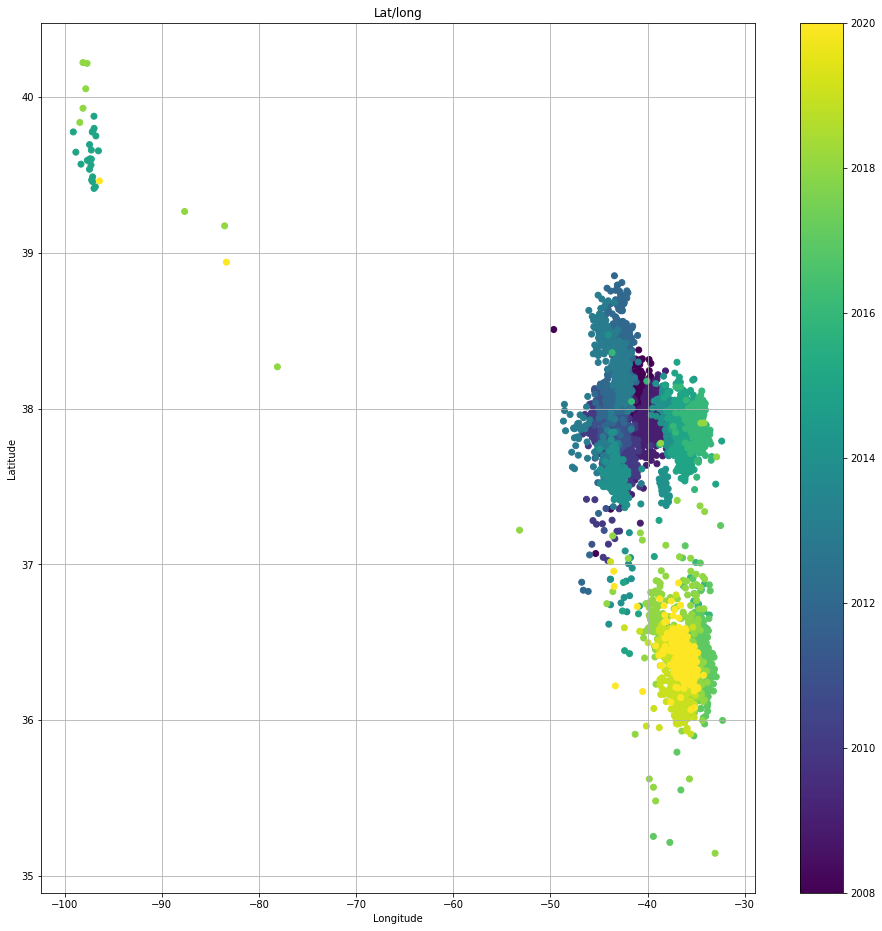

In [24]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()

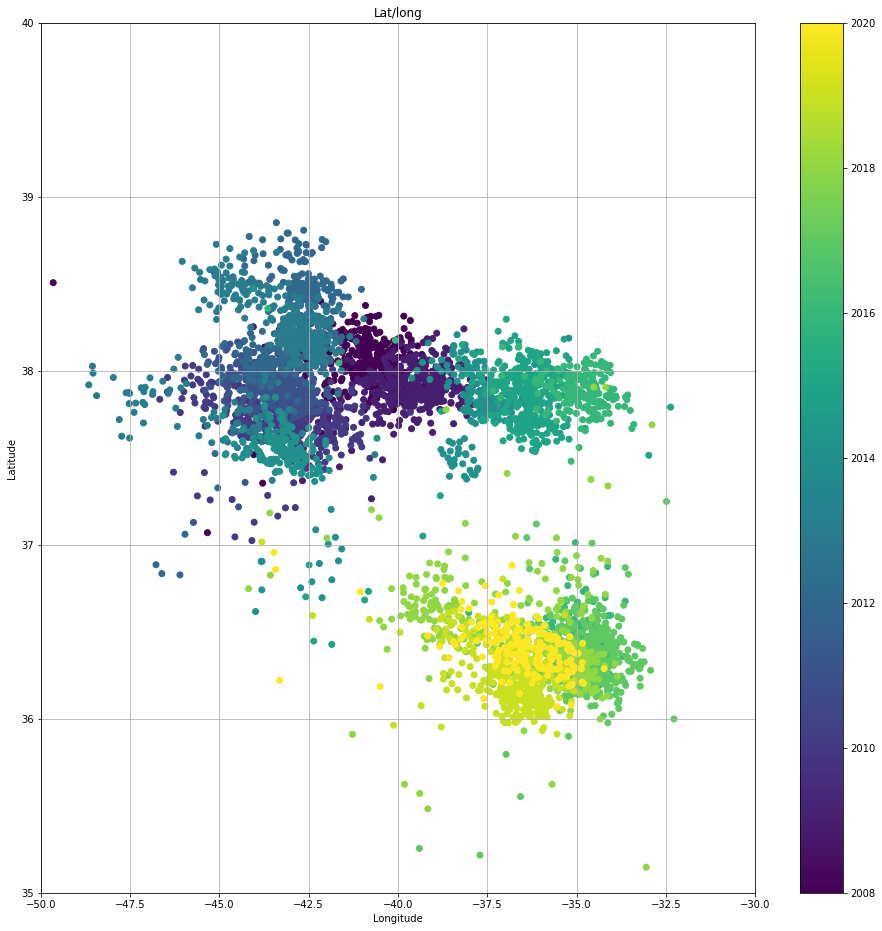

In [25]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-50, -30]) # zoom in 
plt.ylim([35, 40])   # zoom in 
plt.grid()
plt.colorbar()

In [26]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 49.1 s, sys: 3.54 s, total: 52.7 s
Wall time: 1min 43s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


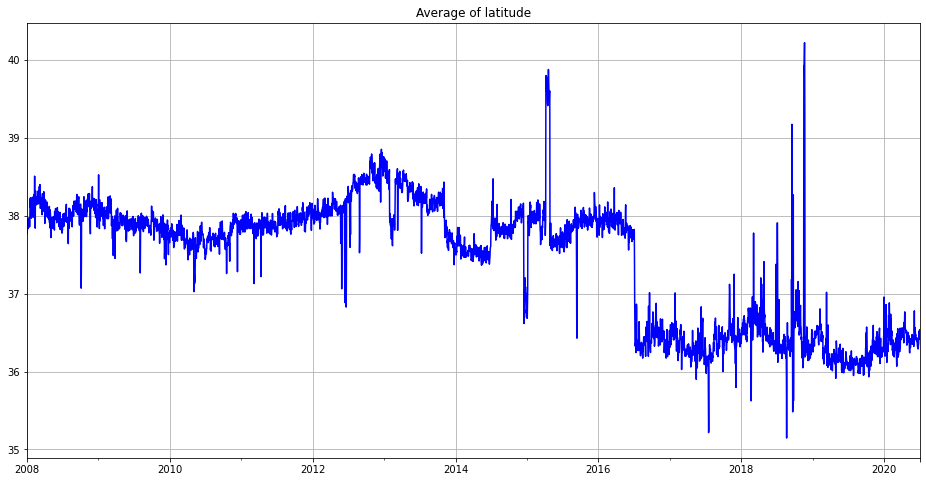

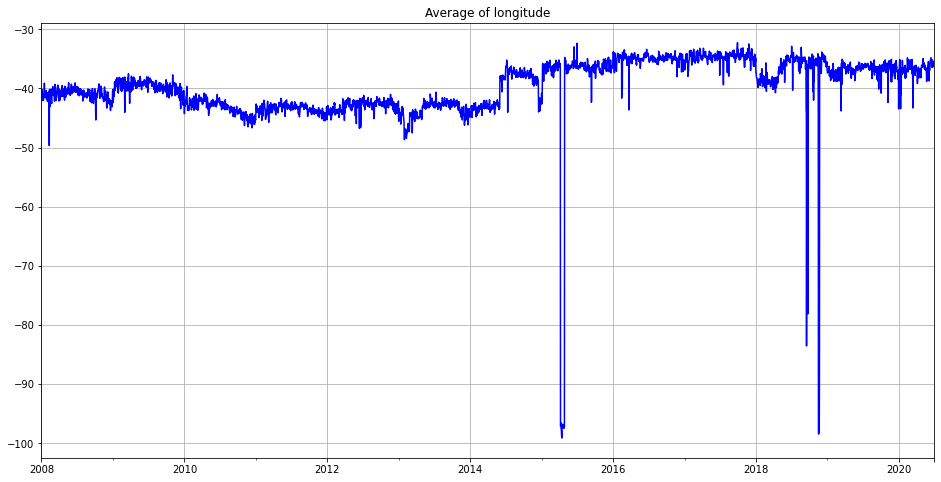

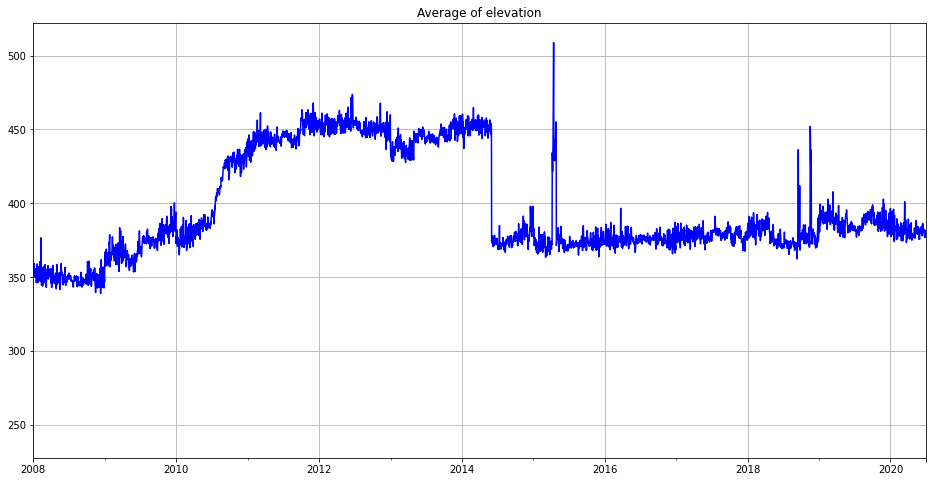

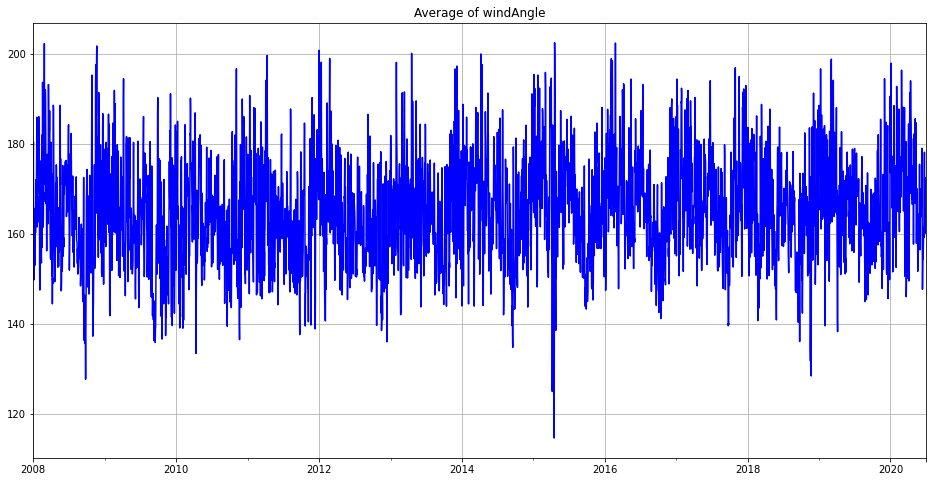

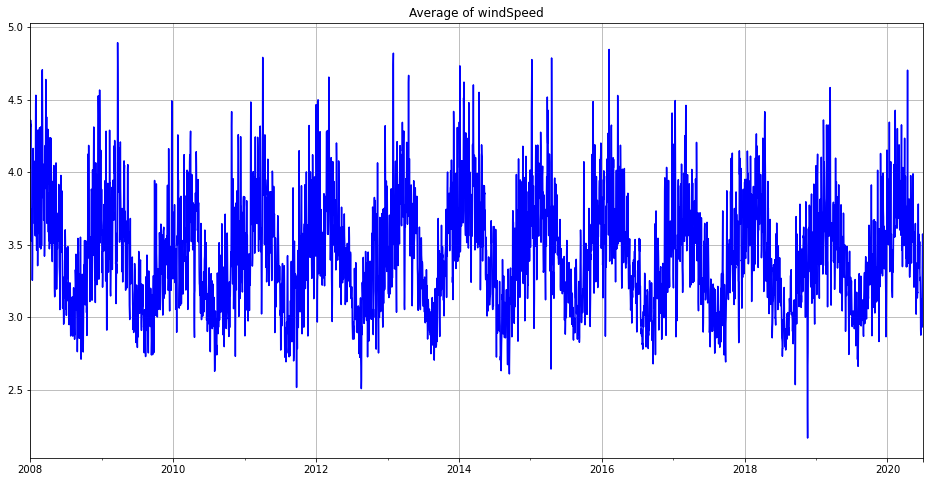

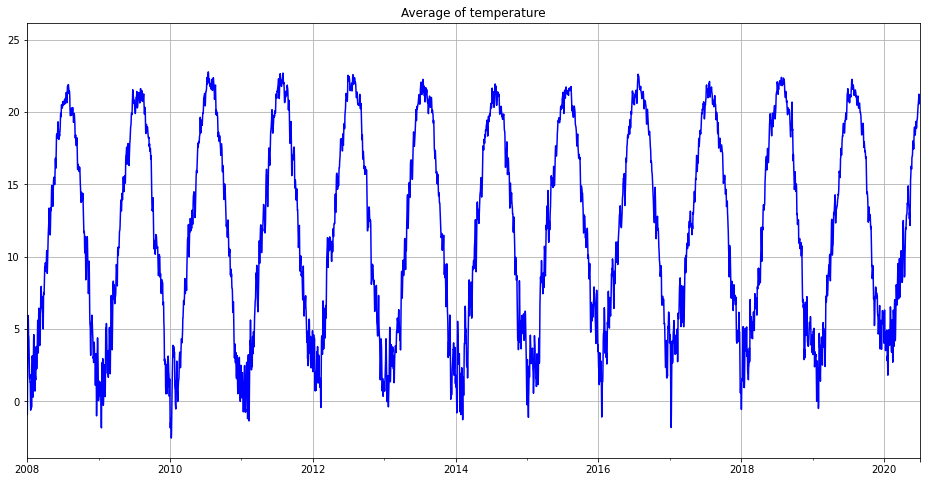

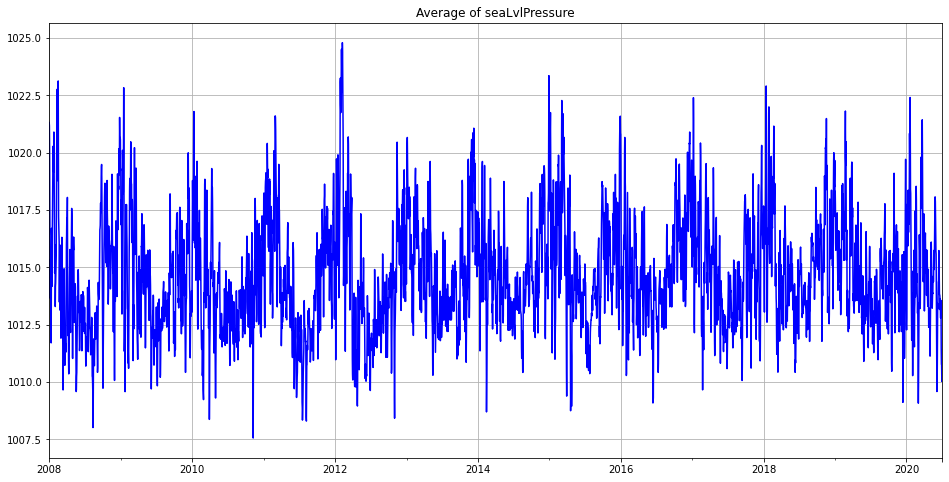

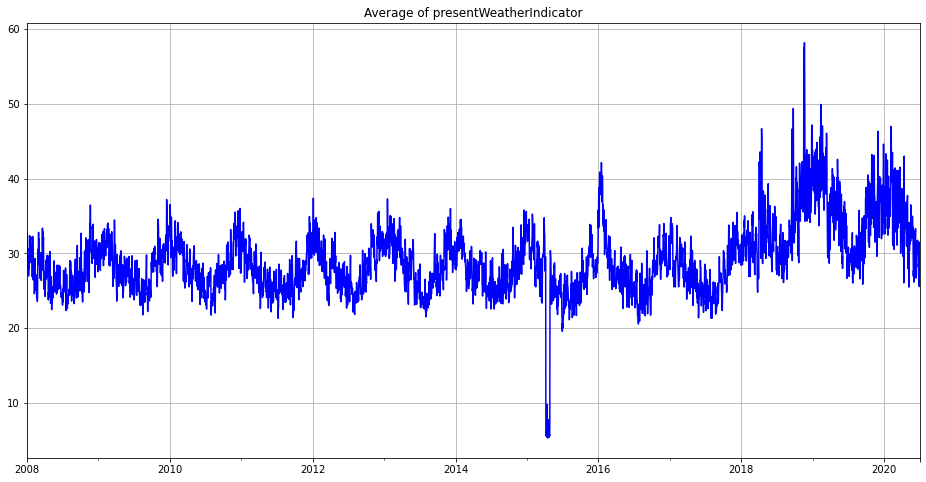

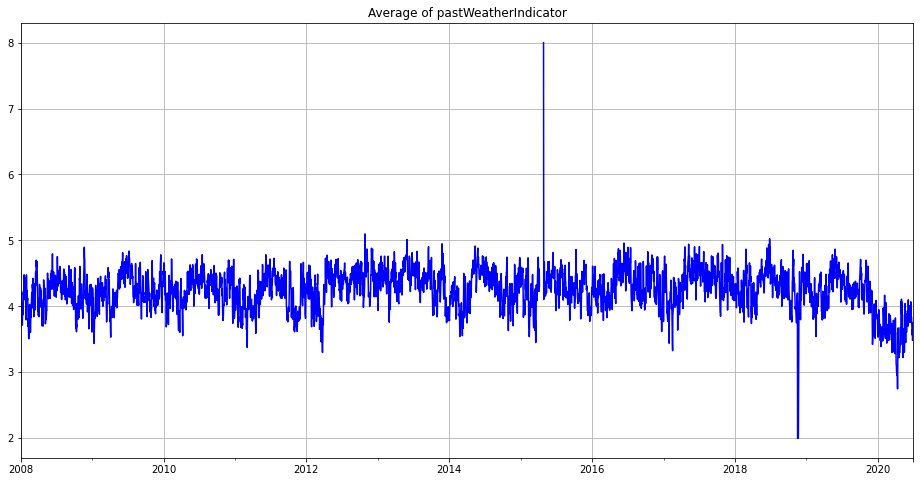

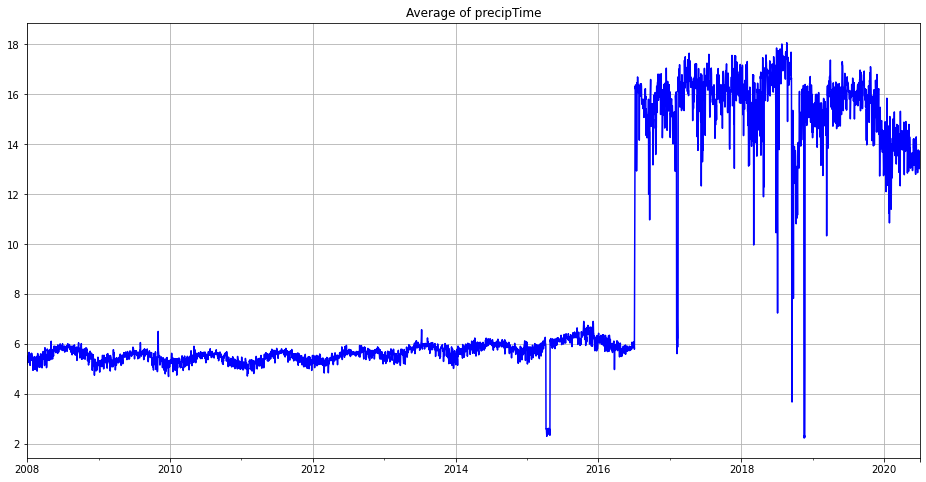

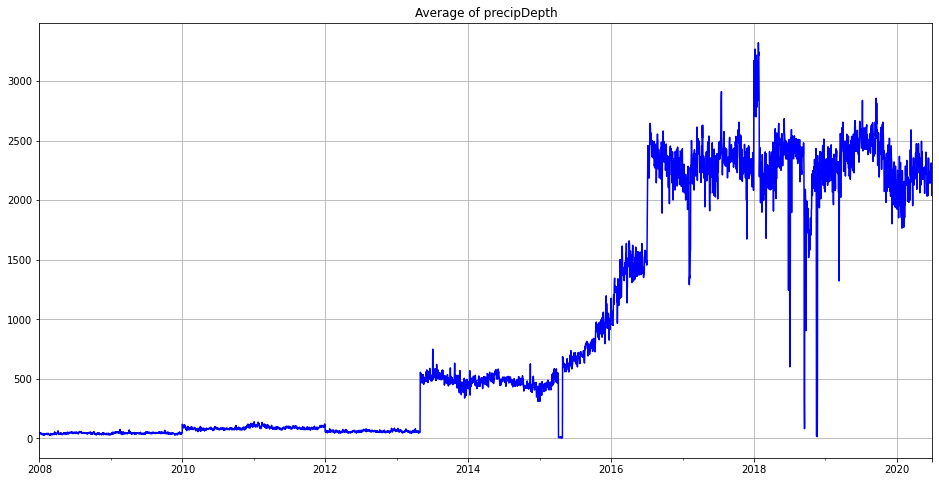

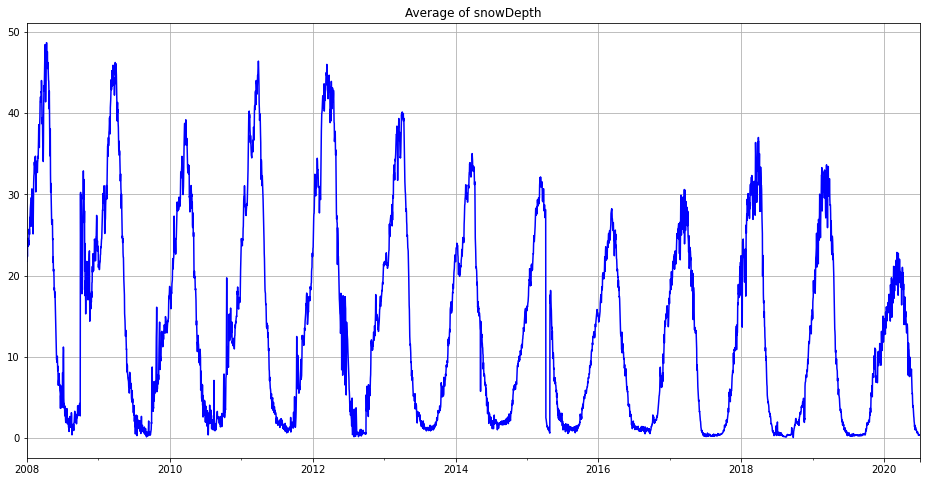

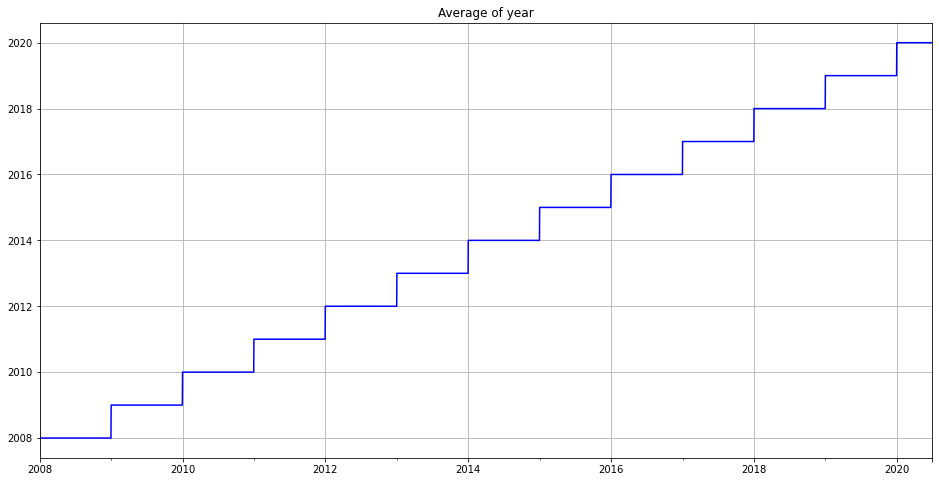

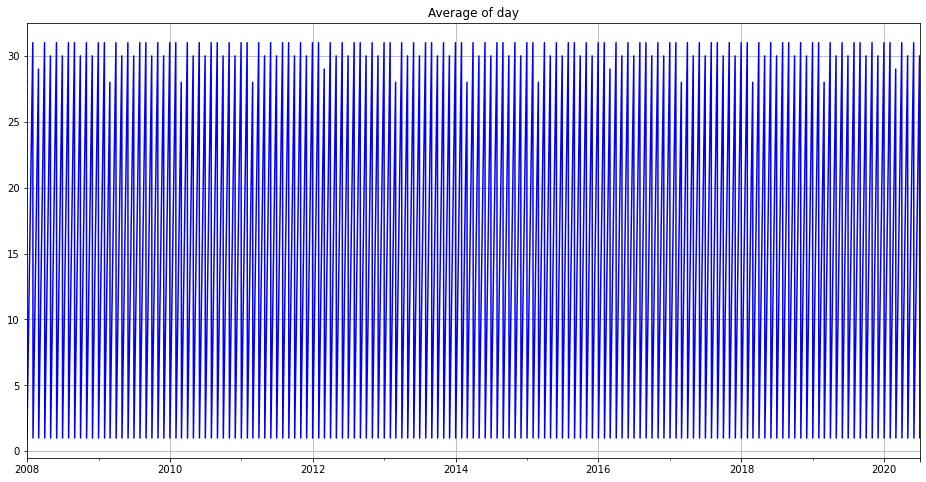

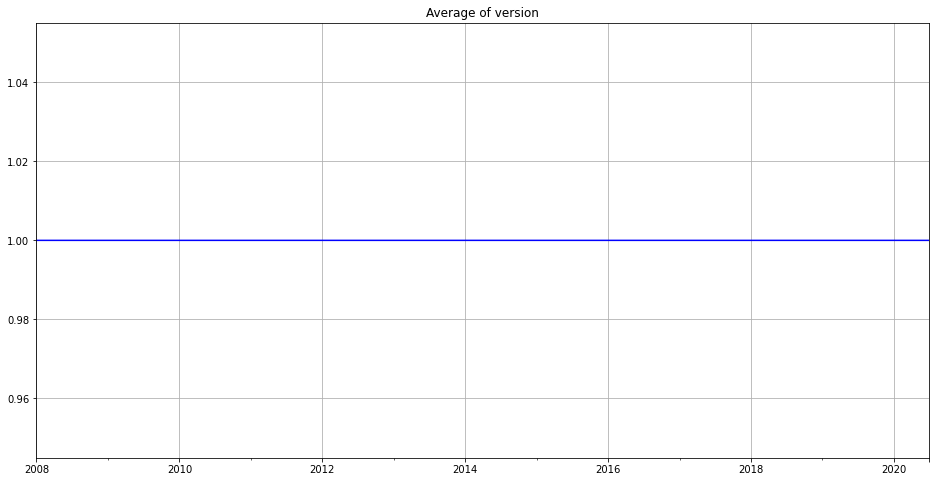

In [27]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2020, 7, 1)])
    plt.grid()

In [28]:
## insert any Pandas-like Dask transformation code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

In [29]:
# %time df.to_csv('/tmp/data/noaa-isd-csv')

In [30]:
# %time df = dd.read_csv('/tmp/data/noaa-isd-csv/*.part', dtype={'usaf': 'object'}, blocksize=None).persist()

In [31]:
%time len(df)

CPU times: user 6.79 s, sys: 400 ms, total: 7.19 s
Wall time: 10.5 s


1478779330

In [32]:
# begin data prep for ML 
df = df.fillna(0)

In [33]:
cols = list(df.columns)
cols = [col for col in cols if df.dtypes[col] != 'object' and col not in ['version', 'datetime']]
cols

['latitude',
 'longitude',
 'elevation',
 'windAngle',
 'windSpeed',
 'temperature',
 'seaLvlPressure',
 'presentWeatherIndicator',
 'pastWeatherIndicator',
 'precipTime',
 'precipDepth',
 'snowDepth',
 'year',
 'day']

In [34]:
X = df[[col for col in cols if col not in ['temperature']]].persist()
y = df.temperature.persist()
# end data prep for ML

In [39]:
xgb = XGBRegressor(n_estimators=16)
%time xgb.fit(X, y)

CPU times: user 21min 16s, sys: 1min 2s, total: 22min 19s
Wall time: 25min 8s


XGBRegressor(n_estimators=16)

In [40]:
%time y_pred = xgb.predict(X).compute()

CPU times: user 59.7 s, sys: 14.7 s, total: 1min 14s
Wall time: 1min


In [41]:
%time rmse = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5
print(f'Training RMSE: {round(rmse, 3)}')

Training RMSE: 21.689


In [42]:
lgbm = LGBMRegressor(n_estimators=16)
%time lgbm.fit(X, y)

WARNING - Parameter tree_learner not set or set to incorrect value (None), using "data" as default


CPU times: user 6min 31s, sys: 22.4 s, total: 6min 53s
Wall time: 7min 20s


LGBMRegressor(local_listen_port=12400,
              machines='127.0.0.1:12400,127.0.0.1:12401,127.0.0.1:12402,127.0.0.1:12403,127.0.0.1:12404,127.0.0.1:12405,127.0.0.1:12406,127.0.0.1:12407,127.0.0.1:12408,127.0.0.1:12409,127.0.0.1:12410,127.0.0.1:12411,127.0.0.1:12412,127.0.0.1:12413,127.0.0.1:12414,127.0.0.1:12415',
              n_estimators=16, num_machines=16, num_threads=8, time_out=120,
              tree_learner='data')

In [43]:
%time y_pred = lgbm.predict(X).compute()

CPU times: user 1min 55s, sys: 1min 34s, total: 3min 29s
Wall time: 1min 41s


In [44]:
%time rmse2 = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5
print(f'Training RMSE: {round(rmse2, 3)}')

CPU times: user 48.5 s, sys: 17.4 s, total: 1min 5s
Wall time: 50.6 s
Training RMSE: 18.303


In [45]:
if rmse2 < rmse:
    best_model = 'lgbm'
else:
    best_model = 'xgb'

best_model

'lgbm'

In [48]:
model_path = f'{best_model}_noaa_isd.joblib.dat'
joblib.dump(xgb, model_path) if best_model is 'xgb' else joblib.dump(lgbm, model_path)
model2 = joblib.load(model_path)

In [52]:
model = Model.register(ws, 
                       model_name      = f'{best_model}-noaa-isd', 
                       model_path      = model_path,
                       description     = f'NOAA ISD temperature predictor')

Registering model lgbm-noaa-isd
